In [0]:
import string
import numpy as np
import matplotlib.pyplot as plt
#import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing import text 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, LSTM, Dense,  Dropout)
from tensorflow.keras.activations import sigmoid, relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds

%matplotlib inline

In [2]:
imdb, info = tfds.load('imdb_reviews', with_info=True)
train, test = imdb['train'], imdb['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete75WC1M/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete75WC1M/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete75WC1M/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [0]:
train_text = train.map(lambda x: x['text'])
test_text = test.map(lambda x: x['text'])

train_labels = train.map(lambda x: x['label'])
test_labels = test.map(lambda x: x['label'])

In [4]:
%%time
# Tensors to raw labels convertation
trainlabs_np = np.array(list(map(lambda x: x.numpy(), train_labels)))
testlabs_np = np.array(list(map(lambda x: x.numpy(), test_labels)))

CPU times: user 16.4 s, sys: 5.35 s, total: 21.7 s
Wall time: 13.2 s


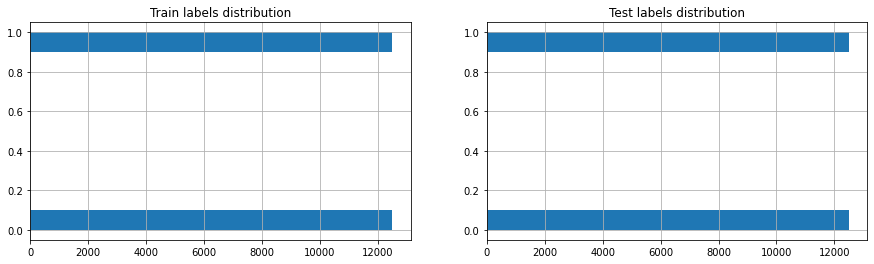

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist(trainlabs_np, orientation='horizontal')
ax[0].set_title('Train labels distribution')
ax[0].grid()
ax[1].hist(testlabs_np, orientation='horizontal')
ax[1].set_title('Test labels distribution')
ax[1].grid()

In [6]:
def get_numexamples(data: tfds.core.DatasetInfo, key: str) -> int:
    return data.splits[key].num_examples

lengths = [get_numexamples(info, key)
           for key in ['train', 'test']] 

print(f'Train, test lengths: {lengths}')

Train, test lengths: [25000, 25000]


In [7]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
punc_signs = string.punctuation
punc_signs

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
nltk.download('punkt')

# Extract lower byte string from tensor in certain encoding
def bytes_to_raw(data: tf.Tensor) -> str:
    return data.numpy().decode('utf8').lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
%%time
# Decode tensors to raw lowered strings
train_text = list(map(bytes_to_raw, train_text))
test_text = list(map(bytes_to_raw, test_text))

CPU times: user 17 s, sys: 5.5 s, total: 22.5 s
Wall time: 13.8 s


In [10]:
%%time
import re
import itertools

# Find separate numeric values in corpus
train_nums = [re.findall(r'\d+', text) for text in train_text]
train_nums = set(itertools.chain(*train_nums))
test_nums = [re.findall(r'\d+', text) for text in test_text]
test_nums = set(itertools.chain(*test_nums))
nums = train_nums | test_nums

print(f'Count of numerics: {len(nums)}')

Count of numerics: 863
CPU times: user 1.42 s, sys: 0 ns, total: 1.42 s
Wall time: 1.43 s


In [11]:
%%time
## Break text into tokens - separate words and signs
train_tokenized = [nltk.word_tokenize(text) for text in train_text]
test_tokenized = [nltk.word_tokenize(text) for text in test_text]

CPU times: user 1min 29s, sys: 524 ms, total: 1min 30s
Wall time: 1min 30s


In [12]:
%%time
extra_stop = ["''", "...", "``", "--", "'s", "br"]
all_stops = stopwords + extra_stop

# Clean text from stopwords and numbers
train_tokens = list([
    word for word in words
    if (word not in punc_signs) and (word not in all_stops)
    and (word not in nums)
] for words in train_tokenized)

test_tokens = list([
    word for word in words
    if (word not in punc_signs) and (word not in all_stops)
    and (word not in nums)
] for words in test_tokenized)

CPU times: user 18.2 s, sys: 18.7 ms, total: 18.3 s
Wall time: 18.3 s


In [0]:
# I choosed not to use spacy lemmatization 'cause of it's very low speed

In [13]:
%%time
nltk.download('wordnet')

# Tokens lemmatization
lemmatizer = WordNetLemmatizer()

train_tokens = list([
    lemmatizer.lemmatize(word, pos='v') for word in words
] for words in train_tokens)

test_tokens = list([
    lemmatizer.lemmatize(word, pos='v') for word in words
] for words in test_tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
CPU times: user 27.5 s, sys: 215 ms, total: 27.7 s
Wall time: 27.9 s


In [14]:
%%time
flatten_train = list(itertools.chain(*train_tokens))
print(f'Count of tokens in train corpus: {len(flatten_train)}')
flatten_test = list(itertools.chain(*test_tokens))
print(f'Count of tokens in test corpus: {len(flatten_test)}')

vocab_size = len(set(flatten_train) | set(flatten_test))
print(f'Vocabulary size: {vocab_size}')

Count of tokens in train corpus: 3029167
Count of tokens in test corpus: 2960123
Vocabulary size: 154879
CPU times: user 680 ms, sys: 45 ms, total: 726 ms
Wall time: 724 ms


#### 1) TfIdf + LogReg


In [15]:
# Define vectorizer with 1/20 count of important words
features_count = vocab_size // 20
tfidf_vector = TfidfVectorizer(max_features=features_count)
print('Count of word features: {}'.format(features_count))

Count of word features: 7743


In [0]:
# Build texts with initial content
# (without order, stopwords, lemmatized and lowered)
train_strs = [' '.join(words) for words in train_tokens]
test_strs = [' '.join(words) for words in test_tokens]

In [0]:
# Use tfidf-vect to get tf-idf text representation
train_vectors = tfidf_vector.fit_transform(train_strs)
test_vectors = tfidf_vector.transform(test_strs)

In [18]:
%%time
from sklearn.model_selection import train_test_split

log_reg = LogisticRegression(random_state=1, n_jobs=2)

# Train-val split
x_train, x_val, y_train, y_val = train_test_split(
    train_vectors, trainlabs_np, train_size=0.8, 
    random_state=0, shuffle=True
)

log_reg = log_reg.fit(x_train, y_train)

CPU times: user 51.5 ms, sys: 109 ms, total: 161 ms
Wall time: 1.48 s


In [0]:
def get_classification_metrics(labels, predicted, set_type: str):
    acc = accuracy_score(labels, predicted)
    prec = precision_score(labels, predicted)
    rec = recall_score(labels, predicted)

    print(f'{set_type} accuracy: {acc:.4f}\n'
          f'precision: {prec:.4f}\n'
          f'recall {rec:.4f}')

In [20]:
y_train_pred = log_reg.predict(x_train)
get_classification_metrics(y_train, y_train_pred, 'Train')

Train accuracy: 0.9241
precision: 0.9151
recall 0.9353


In [21]:
y_val_pred = log_reg.predict(x_val)
get_classification_metrics(y_val, y_val_pred, 'Validation')

Validation accuracy: 0.8806
precision: 0.8652
recall 0.8991


In [22]:
y_test_pred = log_reg.predict(test_vectors)
get_classification_metrics(testlabs_np, y_test_pred, 'Test')

Test accuracy: 0.8783
precision: 0.8766
recall 0.8805


#### Tokenizer + Dense network

In [0]:
# Define tokenizer with count of important words
# equals to 1/20 part of full vocabulary
# and fit on training part
tokenizer = text.Tokenizer(num_words=features_count)
tokenizer.fit_on_texts(train_strs)

In [0]:
dictionary = tokenizer.word_index

# Tokens to respective indices in dictionary convertation
def text_to_indices(text_):
    return [dictionary[word] for word in text.text_to_word_sequence(text_)]

In [0]:
train_indices = [text_to_indices(text) for text in train_strs]
train_indices = np.asarray(train_indices)

# Indices binarization
x_train = tokenizer.sequences_to_matrix(train_indices, mode='binary')

In [0]:
y_train = to_categorical(trainlabs_np, 2)
y_test = to_categorical(testlabs_np, 2)

In [0]:
class ReviewClassifierNN(Model):
    def __init__(self):
        super(ReviewClassifierNN, self).__init__()
        self.fc1 = Dense(64, input_shape=(features_count,),
                         activation=relu)
        self.drop1 = Dropout(0.5)
        self.fc2 = Dense(256, activation=sigmoid)
        self.drop2 = Dropout(0.5)
        self.fc3 = Dense(64, activation=sigmoid)
        self.drop3 = Dropout(0.5)
        self.fc4 = Dense(2, activation=sigmoid)

    def call(self, x):
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        x = self.fc3(x)
        x = self.drop3(x)
        x = self.fc4(x)
        return x

In [0]:
optim = Adam(0.002)
bce = BinaryCrossentropy(from_logits=True)

In [0]:
model = ReviewClassifierNN()

model.compile(loss=bce, optimizer=optim,
              metrics=[BinaryAccuracy()])

In [30]:
%%time
batch_size_ = 512
epochs_ = 3
val_split = 0.2

history = model.fit(x_train, y_train,
                    batch_size=batch_size_, epochs=epochs_,
                    validation_split=val_split, shuffle=True)

Epoch 1/3

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



40/40 [==============================] - 1s 31ms/step - loss: 0.6941 - binary_accuracy: 0.4999 - val_loss: 0.6746 - val_binary_accuracy: 0.5000
Epoch 2/3
40/40 [==============================] - 1s 22ms/step - loss: 0.5987 - binary_accuracy: 0.7852 - val_loss: 0.5646 - val_binary_accuracy: 0.8791
Epoch 3/3
40/40 [==============================] - 1s 22ms/step - loss: 0.5512 - binary_accuracy: 0.9098 - val_loss: 0.5623 - val_binary_accuracy: 0.8786
CPU times: user 5.71 s, sys: 1.04 s, total: 6.75 s
Wall time: 6.73 s


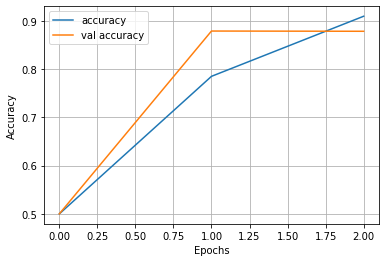

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val accuracy'])
plt.grid()

In [0]:
# Transform test texts into indices according to fitted dictionary
# absent words in dictionary are ignored
def input_to_indices(text_):
    return [dictionary[word] for word in text.text_to_word_sequence(text_)
            if word in dictionary]

In [0]:
test_indices = [input_to_indices(text) for text in test_strs]
test_indices = np.asarray(test_indices)

x_test = tokenizer.sequences_to_matrix(test_indices, mode='binary')

In [0]:
y_pred = model.predict(x_test)

In [0]:
# Convert from probabilities to most probable lable
y_pred = list(map(np.argmax, y_pred))

In [36]:
test_loss, test_acc = model.evaluate(x_test, y_test)
test_acc = accuracy_score(testlabs_np, y_pred)
test_prec = precision_score(testlabs_np, y_pred)
test_rec = recall_score(testlabs_np, y_pred)

782/782 [==============================] - 2s 3ms/step - loss: 0.5634 - binary_accuracy: 0.8767


In [37]:
print(f'Test loss {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}\n'
      f'precision: {test_prec:.4f}\n'
      f'recall {test_rec:.4f}')

Test loss 0.5634
Test accuracy: 0.8778
precision: 0.8840
recall 0.8697


#### Embedding + LSTM network

In [0]:
# Convert texts to word indices sequences
# and pad it to longest string
x_train = pad_sequences(tokenizer.texts_to_sequences(train_strs))
x_test = pad_sequences(tokenizer.texts_to_sequences(test_strs))

In [0]:
class LSTMClassifierNN(Model):
    def __init__(self):
        super(LSTMClassifierNN, self).__init__()
        self.embed = Embedding(features_count, 3)
        self.lstm = LSTM(3)
        self.fc = Dense(2, activation=sigmoid)

    def call(self, x):
        x = self.embed(x)
        x = self.lstm(x)
        x = self.fc(x)
        return x

In [0]:
lstm = LSTMClassifierNN()

lstm.compile(loss=bce, optimizer=optim,
             metrics=[BinaryAccuracy()])

In [46]:
%%time
batch_size_ = 512
epochs_ = 10
val_split = 0.2

history = lstm.fit(x_train, y_train,
                   batch_size=batch_size_, epochs=epochs_,
                   validation_split=val_split, shuffle=True)

Epoch 1/10
40/40 [==============================] - 7s 177ms/step - loss: 0.7022 - binary_accuracy: 0.5094 - val_loss: 0.6710 - val_binary_accuracy: 0.6058
Epoch 2/10
40/40 [==============================] - 7s 165ms/step - loss: 0.6893 - binary_accuracy: 0.5324 - val_loss: 0.6702 - val_binary_accuracy: 0.6510
Epoch 3/10
40/40 [==============================] - 7s 165ms/step - loss: 0.6402 - binary_accuracy: 0.7496 - val_loss: 0.6284 - val_binary_accuracy: 0.8014
Epoch 4/10
40/40 [==============================] - 7s 166ms/step - loss: 0.6088 - binary_accuracy: 0.8437 - val_loss: 0.6069 - val_binary_accuracy: 0.8299
Epoch 5/10
40/40 [==============================] - 7s 166ms/step - loss: 0.5885 - binary_accuracy: 0.8727 - val_loss: 0.6034 - val_binary_accuracy: 0.8202
Epoch 6/10
40/40 [==============================] - 7s 165ms/step - loss: 0.5761 - binary_accuracy: 0.8856 - val_loss: 0.5923 - val_binary_accuracy: 0.8392
Epoch 7/10
40/40 [==============================] - 7s 165ms/ste

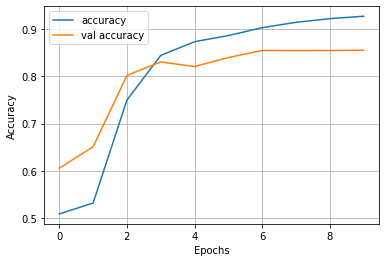

In [47]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val accuracy'])
plt.grid()

In [0]:
y_pred = lstm.predict(x_test)

In [0]:
y_pred = list(map(np.argmax, y_pred))

In [50]:
test_loss, test_acc = lstm.evaluate(x_test, y_test)
test_acc = accuracy_score(testlabs_np, y_pred)
test_prec = precision_score(testlabs_np, y_pred)
test_rec = recall_score(testlabs_np, y_pred)

782/782 [==============================] - 38s 49ms/step - loss: 0.5846 - binary_accuracy: 0.8390


In [52]:
print(f'Test loss {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}\n'
      f'precision: {test_prec:.4f}\n'
      f'recall {test_rec:.4f}')

Test loss 0.5846
Test accuracy: 0.8384
precision: 0.9018
recall 0.7596


#### Conclusions


For plain text classification tasks such imdb reviews ML model usage is enough to achieve great predictive strength.
Above example of logistic regression demonstrated high-valued metrics on all datasets: about of 87, 88 and 92 % respectively on test, val and train.

Metrics for dense network model after tokenization are near to LogReg results, but this model requires more time to be fitted as expected 'cause of it's inner complexity.

LSTM presented less lower results during prediction, but higher than other models (about 93 %!) - during training.
In addition this model consumed much more time to generate predictions. Not much more - for training.
Obvious feature - fast overfitting.
In my opinion in particular case winner among models is LogReg.